In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from esmpy.estimators import SmoothNMF
from esmpy.measures import find_min_angle, find_min_MSE, ordered_mse


In [121]:
C = 15
L = 200
P = 100**2
seed = 0
n_poisson = 300


In [122]:
def syntheticG(L=200, C=15, seed=None):

    np.random.seed(seed=seed)
    n_el = 118
    n_gauss = np.random.randint(2, 7,[C])
    l = np.arange(0, 1, 1/L)
    mu_gauss = np.random.rand(n_el)
    sigma_gauss = 1/n_el + np.abs(np.random.randn(n_el))/n_el*3

    G = np.zeros([L,C])

    def gauss(x, mu, sigma):
        # return np.exp(-(x-mu)**2/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        return np.exp(-(x-mu)**2/(2*sigma**2))

    for i, c in enumerate(n_gauss):
        inds = np.random.choice(n_el, size=[c] , replace=False)
        for ind in inds:
            w = 0.3+0.7*np.random.rand()
            G[:,i] += w * gauss(l, mu_gauss[ind], sigma_gauss[ind])
    return G

def load_toy_images(downsampling_factor):
    im1 = plt.imread("../esmpy/datasets/toy-problem/phase1.png")

    im1 = (1-np.mean(im1, axis=2)) *0.5

    im2 = plt.imread("../esmpy/datasets/toy-problem/phase2.png")
    im2 = (1-np.mean(im2, axis=2)) *0.5

    im0 = 1 - im1 - im2 

    Hdot = np.array([im0, im1, im2])
    n = downsampling_factor
    b = Hdot.shape[2]//n

    Hdot = Hdot.reshape(3, -1, n, b, n).sum((-1, -3)) /(n*n)

    return Hdot


def create_toy_problem(L, C, n_poisson, downsampling_factor, seed=None):
    np.random.seed(seed=seed)
    G = syntheticG(L,C, seed=seed)
    Hdot = load_toy_images(downsampling_factor)
    K = len(Hdot) 
    Hdotflat = Hdot.reshape(K, -1)
    Wdot = np.abs(np.random.laplace(size=[C, K]))
    Ddot = G @ Wdot
    Ydot = Ddot @ Hdotflat
    Y = 1/n_poisson * np.random.poisson(n_poisson * Ydot)
    shape_2d = Hdot.shape[1:]
    return G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K

def plot_results(Ddot, D, Hdotflat, Hflat):
    fontsize = 30
    scale = 15
    aspect_ratio = 1.4
    marker_list = ["-o","-s","->","-<","-^","-v","-d"]
    mark_space = 20
    # cmap = plt.cm.hot_r    
    cmap = plt.cm.gray_r
    vmax = 1
    vmin = 0
    K = len(H)
    L = len(D)
    
    angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    mse = ordered_mse(Hdotflat, Hflat, true_inds)


    fig, axes = plt.subplots(3,K,figsize = (scale/K * 3 * aspect_ratio,scale))
    x = np.linspace(0,1, num = L)
    for i in range(K): 
        print(Ddot.shape)
        axes[2,i].plot(x,Ddot.T[i,:],'bo',label='truth',linewidth=4)
        axes[2,i].plot(x,D[:,true_inds[i]],'r-',label='reconstructed',markersize=3.5)
        axes[2,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
        axes[2,i].set_xlim(0,1)

        axes[1,i].imshow((Hflat[true_inds[i],:]).reshape(shape_2d),vmin = vmin, vmax = vmax , cmap=cmap)
        axes[1,i].set_title("{:.2f} MSE".format(mse[true_inds[i]]),fontsize = fontsize-2)
        # axes[i,1].set_ylim(0.0,1.0)
        axes[1,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

        im = axes[0,i].imshow(Hdotflat[i].reshape(shape_2d),vmin = vmin, vmax = vmax, cmap=cmap)
        axes[0,i].set_title("Phase {}".format(i),fontsize = fontsize)
        axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
        axes[2,0].legend()

    rows = ["True maps","Reconstructed maps","Spectra"]

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, fontsize=fontsize)


    fig.subplots_adjust(right=0.84)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.3])
    fig.colorbar(im,cax=cbar_ax)

    # fig.tight_layout()

    plt.show()
    
        

# Create a synthetic problem

Text(0.5, 1.0, 'Spectral response of each elements')

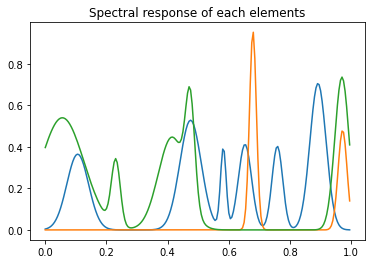

In [123]:
G = syntheticG(L,C, seed)
l = np.arange(0, 1, 1/L)
plt.plot(l, G[:,:3])
plt.title("Spectral response of each elements")


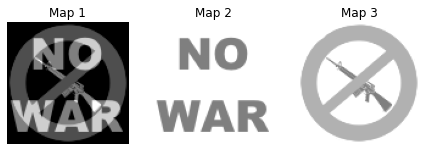

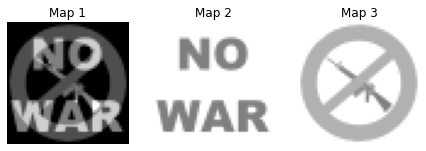

In [124]:

Hdot = load_toy_images(1)
Hdotsmall = load_toy_images(2)


vmin, vmax = 0,1
cmap = plt.cm.gray_r
plt.figure(figsize=(10, 4))
for i, hdot in enumerate(Hdot):
    plt.subplot(1,4,i+1)
    plt.imshow(hdot, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"Map {i+1}")
vmin, vmax = 0,1
cmap = plt.cm.gray_r
plt.figure(figsize=(10, 4))
for i, hdot in enumerate(Hdotsmall):
    plt.subplot(1,4,i+1)
    plt.imshow(hdot, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"Map {i+1}")


In [184]:
G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K = create_toy_problem(L, C, n_poisson,1)

# Solve the problem

In [185]:

mu = 0
lambda_L = 1


params = {}
params["tol"]=1e-6
params["max_iter"] = 50
params["hspy_comp"] = False
params["verbose"] = 1
params["epsilon_reg"] = 1
params["linesearch"] = False
params["shape_2d"] = shape_2d
params["n_components"] = K

estimator = SmoothNMF(mu=mu, lambda_L=lambda_L, G=None, **params)
D = estimator.fit_transform(Y)
Hflat = estimator.H_
H = Hflat.reshape([Hflat.shape[0], *shape_2d])
W = estimator.W_
print(D.shape)

3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 50: loss 0.004,  8.130 it/s
It 20 / 50: loss 0.003,  8.287 it/s
It 30 / 50: loss 0.002,  8.283 it/s
It 40 / 50: loss 0.002,  8.324 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 6.0 seconds.
(200, 3)


In [186]:
        
angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
mse = ordered_mse(Hdotflat, Hflat, true_inds)
print("angles : ", angles)
print("mse : ", mse)

angles :  [0.38785431395715697, 25.225603665850464, 18.278498639432986]
mse :  [0.009551416783443711, 0.0045046410081389125, 0.0038541572485405484]


(200, 3)
(200, 3)
(200, 3)


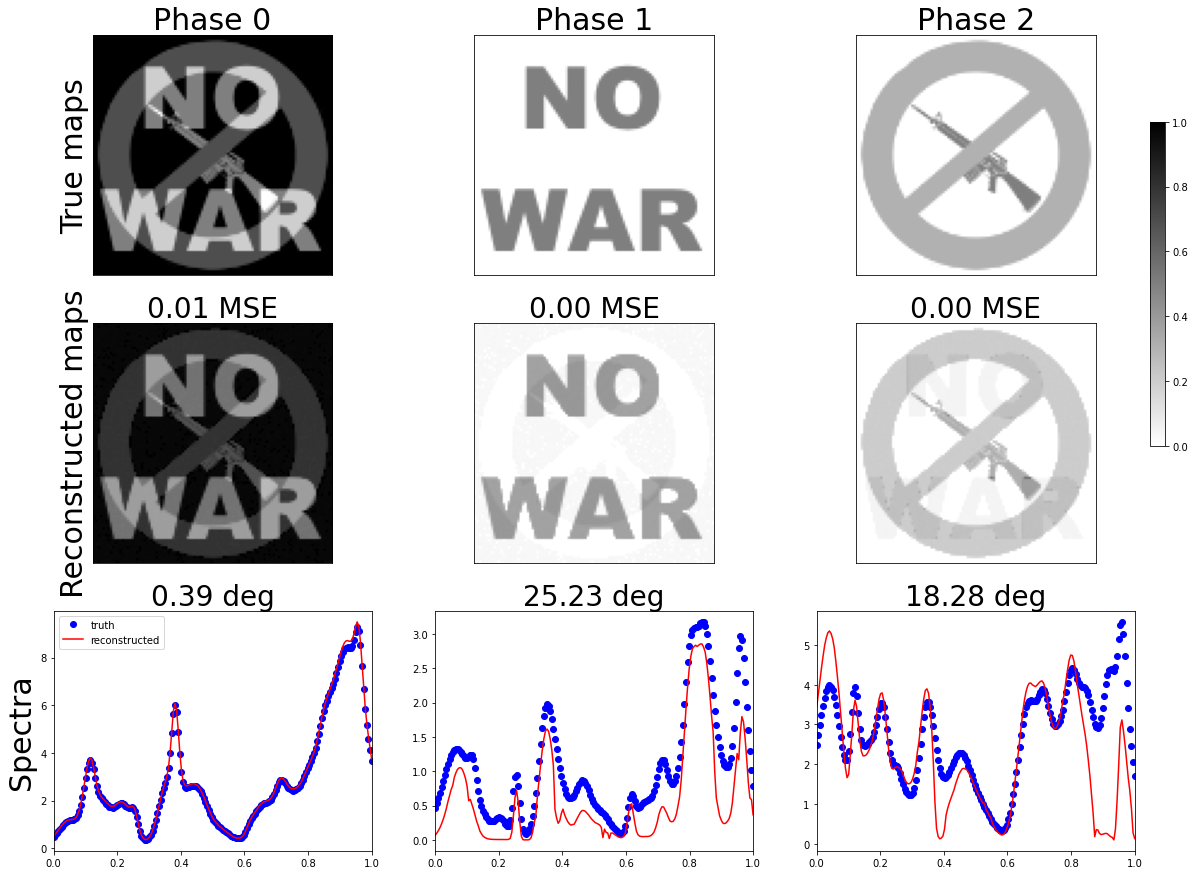

In [187]:
plot_results(Ddot, D, Hdotflat, Hflat)

3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 50: loss 0.027,  9.013 it/s
It 20 / 50: loss 0.024,  8.644 it/s
It 30 / 50: loss 0.023,  8.875 it/s
It 40 / 50: loss 0.021,  9.005 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 6.0 seconds.
angles :  [3.4318817246890156, 24.886780186582236, 12.307158987390556]
mse :  [0.008453212518256235, 0.00219763469155657, 0.010595473345865747]
3
It 10 / 50: loss 0.020,  9.162 it/s
It 20 / 50: loss 0.014,  9.281 it/s
It 30 / 50: loss 0.012,  8.996 it/s
It 40 / 50: loss 0.012,  8.955 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 6.0 seconds.
angles :  [3.3956264524621975, 11.840468300070778, 18.07359033705351]
mse :  [0.021057757178282226, 0.0034386462137165224, 0.011707394178045689]
3
It 10 / 50: loss 0.062,  9.093 it/s
It 20 / 50: loss 0.046,  9.212 it/s
It 30 / 50: loss 0.042,  9.300 it/s
It 40 / 50: loss 0.039,  9.337 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 50: loss 0.011,  32.360 it/s
It 20 / 50: loss 0.009,  33.203 it/s
It 30 / 50: loss 0.007,  33.578 it/s
It 40 / 50: loss 0.006,  33.564 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 1.0 seconds.
angles :  [3.963989424202106, 10.549802104772066, 40.49626910543453]
mse :  [0.032646525146388036, 0.008269201811195358, 0.054007462518774606]
3
It 10 / 50: loss 0.023,  33.796 it/s
It 20 / 50: loss 0.013,  34.237 it/s
It 30 / 50: loss 0.010,  34.361 it/s
It 40 / 50: loss 0.008,  34.493 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 1.0 seconds.
angles :  [20.467563480026662, 16.04417760428418, 18.00685012461951]
mse :  [0.5255772575819502, 0.03808441247351855, 0.4560865801798589]
3
It 10 / 50: loss 0.039,  32.706 it/s
It 20 / 50: loss 0.029,  33.554 it/s
It 30 / 50: loss 0.025,  33.930 it/s
It 40 / 50: loss 0.023,  34.072 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 20 / 50: loss 0.029,  116.268 it/s
It 30 / 50: loss 0.024,  112.728 it/s
It 40 / 50: loss 0.021,  114.656 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 seconds.
angles :  [9.530229136665673, 27.858228029875292, 17.72561507963923]
mse :  [0.2991238276643924, 0.24503227718163467, 0.010269040915696661]
3
It 10 / 50: loss 0.046,  114.195 it/s
It 20 / 50: loss 0.030,  116.280 it/s
It 30 / 50: loss 0.024,  115.433 it/s
It 40 / 50: loss 0.022,  116.231 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 seconds.
angles :  [4.939932605920119, 25.361872918816815, 17.10230493186017]
mse :  [0.06405114726018014, 0.03375922841640475, 0.026808059971517834]
3
It 10 / 50: loss 0.034,  113.749 it/s
It 20 / 50: loss 0.026,  115.890 it/s
It 30 / 50: loss 0.023,  118.749 it/s
It 40 / 50: loss 0.021,  116.908 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 second

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 20 / 50: loss 0.005,  179.659 it/s
It 30 / 50: loss 0.005,  173.630 it/s
It 40 / 50: loss 0.005,  174.288 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 seconds.
angles :  [2.1099582320404386, 10.05699615258654, 10.114277041881945]
mse :  [0.015308590562771639, 0.004534740182206969, 0.008586837276911771]
3
It 10 / 50: loss 0.025,  169.742 it/s
It 20 / 50: loss 0.013,  176.420 it/s
It 30 / 50: loss 0.010,  177.856 it/s
It 40 / 50: loss 0.008,  180.058 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 seconds.
angles :  [3.206195906552946, 9.970392127192675, 17.64397289144679]
mse :  [0.0240620458684651, 0.007848053784425678, 0.011657814839951484]
3
It 10 / 50: loss 0.030,  178.041 it/s
It 20 / 50: loss 0.018,  178.209 it/s
It 30 / 50: loss 0.014,  178.606 it/s
It 40 / 50: loss 0.013,  178.582 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 sec

/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 50: loss 0.052,  432.563 it/s
It 20 / 50: loss 0.043,  404.317 it/s
It 30 / 50: loss 0.040,  401.441 it/s
It 40 / 50: loss 0.040,  401.152 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 seconds.
angles :  [11.203802860029208, 14.270335261044139, 15.097255663618972]
mse :  [0.06143960904492715, 0.03537786285334342, 0.012579753139655448]
3
It 10 / 50: loss 0.030,  434.049 it/s
It 20 / 50: loss 0.023,  438.471 it/s
It 30 / 50: loss 0.020,  445.123 it/s
It 40 / 50: loss 0.019,  443.080 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 0.0 seconds.
angles :  [18.158548912590394, 26.95071933702809, 17.498051589047876]
mse :  [0.5126183710092801, 0.4249927256731183, 0.015092726225102698]


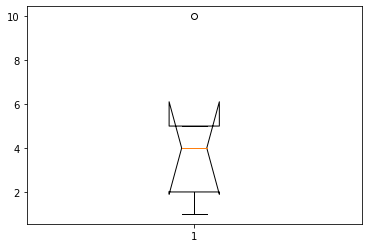

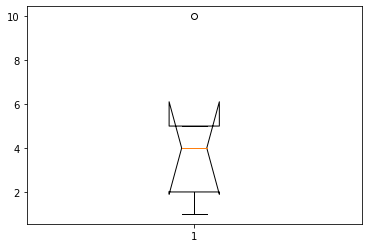

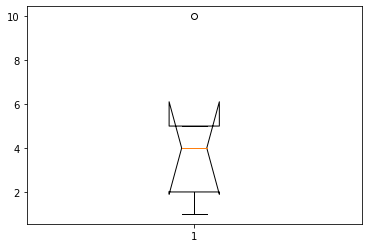

In [211]:
sampling_factors = [1,2,4,5,10]
results_0 = []
results_1 = []
results_2 = []

for i in range(len(sampling_factors)):
    downsample_factor_results_0 = []
    downsample_factor_results_1 = []
    downsample_factor_results_2 = []
    W = None
    Hflat = None
    for j in range(3):

        G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K = create_toy_problem(L, C, n_poisson,sampling_factors[i])
        mu = 0
        lambda_L = 1


        params = {}
        params["tol"]=1e-6
        params["max_iter"] = 50
        params["hspy_comp"] = False
        params["verbose"] = 1
        params["epsilon_reg"] = 1
        params["linesearch"] = False
        params["shape_2d"] = shape_2d
        params["n_components"] = K

        estimator = SmoothNMF(mu=mu, lambda_L=lambda_L, G=G, **params)
        # print(Y.shape, G.shape, Hflat.shape, H.shape, Hdot.shape)

        D = estimator.fit_transform(Y, y=None, W = W, H = Hflat)
        Hflat = estimator.H_
        H = Hflat.reshape([Hflat.shape[0], *shape_2d])
        W = estimator.W_

        angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
        mse = ordered_mse(Hdotflat, Hflat, true_inds)
        print("angles : ", angles)
        print("mse : ", mse)
        downsample_factor_results_0.append(angles[0])
        downsample_factor_results_1.append(angles[1])
        downsample_factor_results_2.append(angles[2])

    results_0.append(downsample_factor_results_0)
    results_1.append(downsample_factor_results_1)
    results_2.append(downsample_factor_results_2)


plt.boxplot(results_0)
plt.show()

plt.boxplot(results_1)
plt.show()

plt.boxplot(results_2)
plt.show()

In [191]:
print(results)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
